<h1 style = "font-size:3rem;color:orange">Pitch Estimation Comparison</h1>

Comparing two correlation methods (autocorrelation and comb-filtering) and harmonic summation

In [26]:
import numpy as np
import matplotlib.pyplot as plt  
import librosa                    
import librosa.display            

Import audio and plot in frequency domain

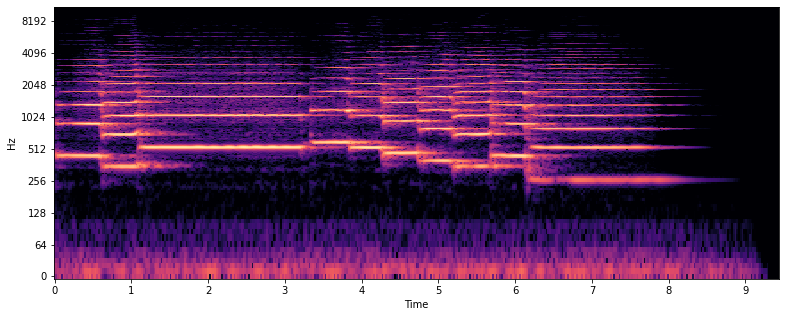

In [27]:
x , sr = librosa.load('../samples/trumpetFull.wav')
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (13, 5))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

<h1 style = "font-size:3rem;color:orange">Autocorrelation</h1>

Correlation methods are using the periodic relation of the signal by measuring the difference $e(n)$, or error, between the input signal $x(n)$ and delayed input signal $x(n-\tau)$: 

\begin{equation}
    e(n) = x(n) - ax(n-\tau),
\end{equation}

where $a$ is a scalar to account for amplitude changes.\\\\


Getting the size of the error by squaring, yielding the objective function $J(a,\tau)$:

\begin{equation}
    J(a,\tau) = \sum_{n=\tau}^{N-1} |e(n)|^2.
\end{equation}

With autocorrelation, the objective function is rewriting:

\begin{align}
     J(a,\tau) &= \sum_{n=\tau}^{N-1} |e(n)|^2 \\
               &=\sum_{n=\tau}^{N-1} x^2(n) - \sum_{n=\tau}^{N-1}a^2x^2(x-\tau) -2aR(\tau),
\end{align}

with autocorrelation function $R(\tau) = \sum_{n=\tau}^{N-1}x(n)x(n-\tau)$, which needs to maximized in order to minimize the objective function: 

\begin{equation}
    \hat{\tau} = \operatorname*{argmax}_{\tau \in [\tau_{min}, \tau_{max}]} R(\tau).
\end{equation}


Code example autocorrelation:

In [28]:
def autocorrelation(data, minFreq, maxFreq):    
    nData = len(data);
    minTau = int(max(1,np.ceil(1 / maxFreq)));        # Minimum period
    maxTau = int(min(nData,np.floor(1 / minFreq)));   # Maximum period
    nTau = int(maxTau - minTau);
    
    objectiveFunc = np.zeros(nTau);            # Objective funciton we want to minimize
    
    for tau in range(minTau,maxTau):
        xt = data[range(0,len(data)-1-tau)];               # Trimeed delayed input signal
        x = data[range(tau,len(data)-1)];                  # Trimmed input data
        
        autoCor = 0;
        
        for n in range(0,len(x)):
            autoCor = autoCor + (1/(nData-tau))*x[n]*xt[n]; # Using the autocorrelation function
        
        objectiveFunc[tau-minTau] = max(autoCor,0);         # Put the outcome into the objective function vec
    
    index = np.argmax(objectiveFunc);
    pitch = 1/(index+minTau);
    
    
    return pitch

<h1 style = "font-size:3rem;color:orange">Comb-filtering</h1>

Similar to autocorrelation, but more accurate as it also includes scalar $a$, that accounts for amplitude changes.
The difference, or error, between the signal and shifted signal is $e[n] = x[n] - ax[n-\tau]$

Then the objective function is obtained by squaring the error (finding the size) and going through a set of periods:

$J(a,\tau) = \sum_{n=\tau}^{N-1}e[n]^2$

Then the pitch can be obtained by minimizing the objective function: 

$\hat{\tau} = argmin \ J(a, \tau)$.

Finding $a$:

\begin{align}
     J(a,\tau) &= \sum_{n=\tau}^{N-1} |e(n)|^2 = \sum_{n=\tau}^{N-1} |x(n) - ax(n-\tau)|^2\\
               &=\sum_{n=\tau}^{N-1} x^2(n) + a^2\sum_{n=\tau}^{N-1}x^2(n-\tau) -2a\sum_{n=\tau}^{N-1}x(n)x(n-\tau) \\
      \frac{dJ}{da} &= 2a\sum_{n=\tau}^{N-1}x^2(n-\tau) -2\sum_{n=\tau}^{N-1}x(n)x(n-\tau).\\
      \frac{dJ}{da} &= 0 \Longrightarrow a = \frac{\sum_{n=\tau}^{N-1}x(n)x(n-\tau)}{\sum_{n=\tau}^{N-1}x^2(n-\tau)}.
\end{align}

Inserting $a$ into the objective function:

\begin{align}
   \hat{\tau} &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} J(a,\tau)\\
    &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} \left[ \sum_{n=\tau}^{N-1} x^2(n) -2 \frac{\sum_{n=\tau}^{N-1}x^2(n)x^2(n-\tau)}{\sum_{n=\tau}^{N-1}x^2(n-\tau)} + \frac{\sum_{n=\tau}^{N-1}x^2(n)x^4(n-\tau)}{\sum_{n=\tau}^{N-1}x^4(n-\tau)}\right]\\
    &= \operatorname*{argmin}_{\tau \in [\tau_{min}, \tau_{max}]} \left[ \sum_{n=\tau}^{N-1} x^2(n) - \frac{\left[\sum_{n=\tau}^{N-1}x(n)x(n-\tau)\right]^2}{\sum_{n=\tau}^{N-1}x^2(n-\tau)}\right].
\end{align}

Function for estimating pitch using comb-filtering: 

In [35]:
def comb_filtering(data, minFreq, maxFreq):    
    nData = len(data);
    minTau = int(max(1,np.ceil(1 / maxFreq)));        # Minimum period
    maxTau = int(min(nData,np.floor(1 / minFreq)));   # Maximum period
    nTau = int(maxTau - minTau);
    
    objectiveFunc = np.zeros(nTau);            # Objective funciton we want to minimize
    
    for tau in range(minTau,maxTau):
        xt = data[range(0,len(data)-1-tau)];               # Trimeed delayed input signal
        x = data[range(tau,len(data)-1)];                  # Trimmed input data
        
        xSumSq = 0;   # Summed input signal squared
        xtSumSq = 0;  # Summed delayed input signal squared 
        xxtSum = 0;   # Summed input * delyed input
        
        for n in range(0,len(x)):
            xSumSq = xSumSq + x[n]*x[n];          # Summed input signal squared
            xtSumSq = xtSumSq + xt[n]*xt[n];      # Summed delayed input signal squared 
            xxtSum = xxtSum + x[n]*xt[n];         # Summed input * delayed input
        
        crosscor = xSumSq*xtSumSq
        if crosscor != 0:
            normCrossCor = (xxtSum / np.sqrt(crosscor));
        else:
            normCrossCor = 0 
            
        objectiveFunc[tau-minTau] = max(normCrossCor,0); # Put the outcome into the objective function vec
    
    index = np.argmax(objectiveFunc);
    pitch = 1/(index+minTau);
    
    
    return pitch

<h1 style = "font-size:3rem;color:orange">Harmonic Summation</h1>

The pitch, or fundamental period $\tau$ can be estimated using the autocorrelation function, which is based on the similarity between the original and shifted signal:

$r_x = \sum_{n=0}^{N-1}x[n] \cdot x[n+\tau]$

Then the pitch can be obtained by going trough a set of periods and minimizing the objective function. 

<h1 style = "font-size:3rem;color:orange">Comparison</h1>

Break data into segments

In [39]:
min_freq = 100;                                        # Minimum frequency that can be estimated
max_freq = 1000;                                       # Maximum frequency that can be estimated
 
norm_min_freq = min_freq / sr;                         # Normalized min frequency            
norm_max_freq = max_freq / sr;                         # Normalized max frequency

overlap = 50;                                          # Percentage overlap from previous segment
nData = len(x);                                        # Total amount of samples
segmentLength =  100/1000;                              # Length of each segment in miliseconds
nSegmentLength = segmentLength * sr;                   # Segment Length in samples

nShift = int(round((1-overlap/100)*nSegmentLength));        # Segment shift in samples
number_of_segments = int(np.ceil((nData-nSegmentLength+1)/nShift));  # Total amount of segments                                   

Autocorrelation

In [45]:
iVector = list(range(1, int(nSegmentLength) + 1));      # Vector used for indexing
pitchVecAC = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVecAC[iVector] =  autocorrelation(x[iVector], norm_min_freq, norm_max_freq);              # Estimate pitch using Auto Correlation
    iVector = [z+nShift for z in iVector];
    print(f'Processing section {i+1} of {number_of_segments}')

Processing section 1 of 187
Processing section 2 of 187
Processing section 3 of 187
Processing section 4 of 187
Processing section 5 of 187
Processing section 6 of 187
Processing section 7 of 187
Processing section 8 of 187
Processing section 9 of 187
Processing section 10 of 187
Processing section 11 of 187
Processing section 12 of 187
Processing section 13 of 187
Processing section 14 of 187
Processing section 15 of 187
Processing section 16 of 187
Processing section 17 of 187
Processing section 18 of 187
Processing section 19 of 187
Processing section 20 of 187
Processing section 21 of 187
Processing section 22 of 187
Processing section 23 of 187
Processing section 24 of 187
Processing section 25 of 187
Processing section 26 of 187
Processing section 27 of 187
Processing section 28 of 187
Processing section 29 of 187
Processing section 30 of 187
Processing section 31 of 187
Processing section 32 of 187
Processing section 33 of 187
Processing section 34 of 187
Processing section 35 o

Comb-filtering

In [46]:
iVector = list(range(1, int(nSegmentLength) + 1));      # Vector used for indexing
pitchVecCF = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVecCF[iVector] =  comb_filtering(x[iVector], norm_min_freq, norm_max_freq);              # Estimate pitch using Auto Correlation
    iVector = [z+nShift for z in iVector];
    print(f'Processing section {i+1} of {number_of_segments}')

Processing section 1 of 187
Processing section 2 of 187
Processing section 3 of 187
Processing section 4 of 187
Processing section 5 of 187
Processing section 6 of 187
Processing section 7 of 187
Processing section 8 of 187
Processing section 9 of 187
Processing section 10 of 187
Processing section 11 of 187
Processing section 12 of 187
Processing section 13 of 187
Processing section 14 of 187
Processing section 15 of 187
Processing section 16 of 187
Processing section 17 of 187
Processing section 18 of 187
Processing section 19 of 187
Processing section 20 of 187
Processing section 21 of 187
Processing section 22 of 187
Processing section 23 of 187
Processing section 24 of 187
Processing section 25 of 187
Processing section 26 of 187
Processing section 27 of 187
Processing section 28 of 187
Processing section 29 of 187
Processing section 30 of 187
Processing section 31 of 187
Processing section 32 of 187
Processing section 33 of 187
Processing section 34 of 187
Processing section 35 o

Plot the estimated pitch and compare to STFT

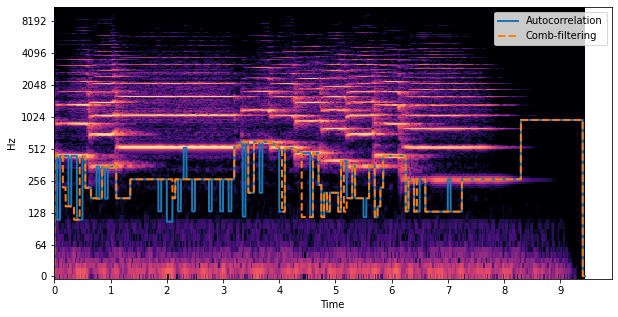

In [47]:
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (10, 5))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

pitch_norm = pitchVec * sr
timeVec = np.arange(0, nData/sr, 1/sr, dtype=np.float64)

plt.plot(timeVec, pitchVecAC*sr, lw=2, label = 'Autocorrelation')
plt.plot(timeVec, pitchVecCF*sr, lw=2, linestyle='dashed', label = 'Comb-filtering')

plt.legend()
plt.show()